In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import h5py

from scipy import special
from pathlib import Path
from sklearn import metrics

def estimate_NN(n_epoch=100):
    path2outputs = Path.home()/'group'/'project'/'scripting'/'output'/\
    '230316_eval_cnn1d'/'model1_standard'/'model1_standard.npz'
    path2ind = Path.home()/'group'/'project'/'scripting'/'output'/\
    '230316_eval_cnn1d'/'model1_standard'/'train_inds.npy'
    path2originaldata = Path.home()/'group'/'project'/'datasets'/'data'/'220901_dl_test_data_85to90deg_5mm.h5'
    originaldata = h5py.File(path2originaldata, 'r')
    pitch_angles = originaldata['meta']['theta_min'][np.load(path2ind)]
    n_pitch = pitch_angles.size
    originaldata.close()
    pitch_angles = np.tile(pitch_angles, 3)
    pitch_angles = np.concatenate((pitch_angles, np.zeros(pitch_angles.size)), axis=0)
    output_file = np.load(path2outputs)
    

    combined_output = []
    combined_pitch = []
    ep_output_shape = ()
    for i, key in enumerate(output_file):
        combined_output.extend(output_file[key])
        combined_pitch.extend(pitch_angles)
        ep_output_shape = output_file[key].shape
        #print(ep_output_shape)
        
    combined_output = np.array(combined_output)
    combined_pitch = np.array(combined_pitch)
    combined_output = special.softmax(combined_output, axis=-1)
    
    labels = np.zeros(ep_output_shape[0], dtype=np.int32)
    labels[0:ep_output_shape[0]//2]=1
    labels = np.tile(labels, n_epoch) # (labels, number of epochs)
    
    fpr, tpr, _ = metrics.roc_curve(labels, combined_output[:, 1])
    
    return labels, combined_output, combined_pitch


In [2]:
labels, output, pitch = estimate_NN(n_epoch=100)
#nn2_fpr, nn2_tpr = estimate_NN2()




# plot pdfs

In [3]:
inds = ((pitch>=85.5)*(pitch<=88.5)+(pitch==0.0))
temp_labels = labels[inds]
temp_output1 = output[inds, 1]
temp_output0 = output[inds, 0]


In [4]:
temp_labels == 0

array([False, False, False, ...,  True,  True,  True])

In [5]:
sns.set_theme(style='whitegrid', context='paper', font_scale=1.65)

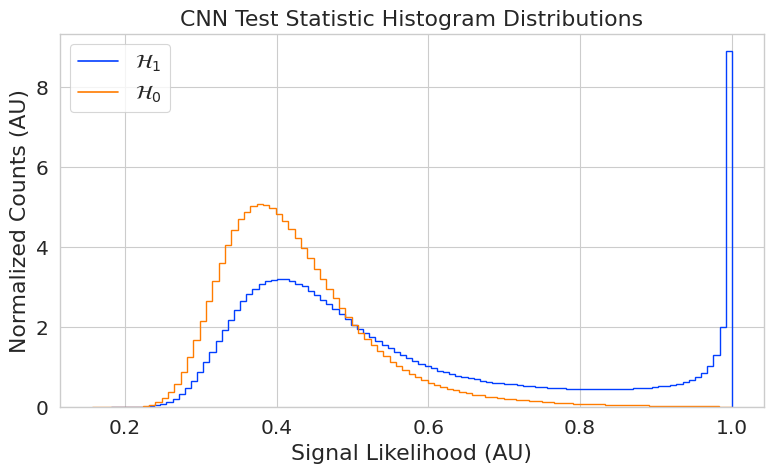

In [6]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
clist = sns.color_palette('bright', n_colors=10)

hist1 = ax.hist(
    temp_output1[temp_labels == 1],
    bins=101,
    histtype='step',
    density=True,
    color=clist[0],
    lw=1
    
)
hist0 = ax.hist(
    temp_output1[temp_labels == 0],
    bins=101,
    histtype='step',
    density=True,
    color=clist[1],
    lw=1
)

line1, = ax.plot([],[], color=clist[0])
line0, = ax.plot([],[], color=clist[1])
ax.legend([line1,line0],[r'$\mathcal{H}_1$', r'$\mathcal{H}_0$'],loc=2)

#ax.set_xlim(-1, 7)
ax.set_xlabel('Signal Likelihood (AU)')
ax.set_ylabel('Normalized Counts (AU)')

ax.set_title('CNN Test Statistic Histogram Distributions')

plt.tight_layout(pad=1.05)
plt.savefig(Path.home()/'group'/'project'/'plots'/'230831_cnn_test_stat_hist', dpi=150)


Text(0.5, 0, '')

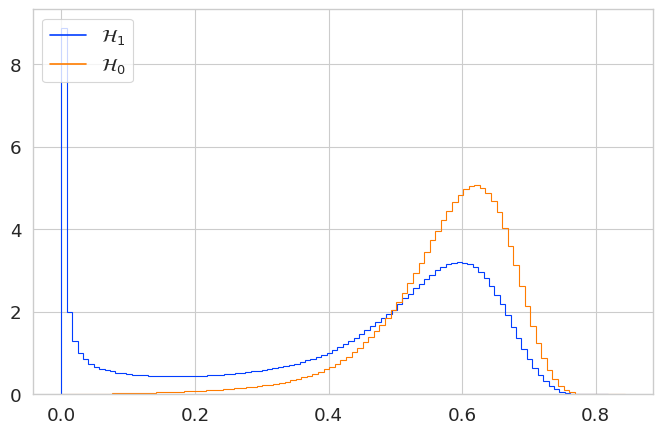

In [47]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
clist = sns.color_palette('bright', n_colors=10)

hist1 = ax.hist(temp_output0[temp_labels == 1], bins=101, histtype='step', density=True, color=clist[0])
hist0 = ax.hist(temp_output0[temp_labels == 0], bins=101, histtype='step', density=True, color=clist[1])

line1, = ax.plot([],[], color=clist[0])
line0, = ax.plot([],[], color=clist[1])
ax.legend([line1,line0],[r'$\mathcal{H}_1$', r'$\mathcal{H}_0$'],loc=2)

#ax.set_xlim(-1, 7)
ax.set_xlabel('')

In [ ]:
nn_fpr_by_pitch = []
nn_tpr_by_pitch = []

for temp_pitch in [85.5]:#88.2, 88.1, 88.0, 87.9, 87.8, 87.7, 87.6, 87.5]:

    inds = ((pitch>=temp_pitch)*(pitch<=temp_pitch+2.9)+(pitch==0.0))
    nn_fpr_temp, nn_tpr_temp, _ = metrics.roc_curve(labels[inds], output[inds, 1])
    
    nn_fpr_by_pitch.append(nn_fpr_temp)
    nn_tpr_by_pitch.append(nn_tpr_temp)

nn_fpr_all, nn_tpr_all, _ = metrics.roc_curve(labels, output[:, 1])

